### Librerias

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, 
    precision_score, recall_score, balanced_accuracy_score, 
    classification_report, confusion_matrix, roc_curve, auc
)


# Interpretabilidad
import shap

# Guardar modelo
import joblib


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Bases

In [2]:
# Base inicial
df_final = pd.read_csv("data/df_final.csv")
df_final['DescRF_Identificacion'] = df_final['DescRF_Identificacion'].astype(str).str.strip()

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_19452\2983733256.py:2: DtypeWarning: Columns (18,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv("C:/Users/Administrator/Downloads/df_final.csv")


### Selección de variables modelo

In [3]:
variables_utiles = [
    'DescRF_Tipo_estado_alumno', # categorica
    'DescRF_Modalidad', # categorica
    'DescRF_Semestre_SINU', # numerica
    'DescRF_ciclo', # categorica
    'DescRF_SEMESTRE_MEN', #numerica
    'DescRF_Genero', # categorica
    'DescRF_Unidad', # categorica
    'DescRF_Jornada', # categorica
    'DescRF_Tipo_Inscripcion', # categorica
    'DescRF_Sede', # categorica
    'DescRF_Regional', # categorica
    'DescRF_Programa', # categorica
    'DescRF_Fondo', # categorica
    'DescRF_Producto', # categorica
    'DescRF_Fuente', # categorica
    'DescRF_REGLA_ACA', # numerica
    'DescRF_REGLA_INGLES', # numerica
    'DescRF_perdida_academica', # numerica
    'DescRF_tiene_grado', # numerica
    'DescRF_graduado', # numerica
    'DescRF_cod_ciclo', # numerica
    'DescRF_Tipo_Alumno', # categorica
    'DescRF_Nuevo', # categorica
    'DescRF_Valor_Liquidado', # numerica
    'DescRF_Creditos_Orden', # numerica
    'DescAM_MATERIAS_INSCRITAS', # numerica
    'DescAM_MATERIAS_APROBADAS', # numerica
    'DescAM_Porcentaje_aprobacion', # numerica
    'EEpromedio', # numerica
    'EE_UNIDADNEGOCIO', # categorica
    'EE_DEPARTAMENTO_REGIONAL', # categorica
    'EE_OTRA_DISCAPACIDAD', # categorica
    'EE_ESTRATO_ACTUALIZADO', # numerica
    'Grupo_Edad', # numerica
    'Trabaja', # categorica
    'Deserto' # binaria formada variable respuesta
]
df_modelo = df_final[variables_utiles].copy()


In [5]:
df_modelo.to_csv('df_modelo_fin.csv', index=False)

### Separación de los datos

In [4]:
df_temp = df_modelo.copy()

variables_categoricas = df_temp.select_dtypes(include=['object', 'category']).columns

# Codificar variables 
le = LabelEncoder()
for col in variables_categoricas:
    df_temp[col] = le.fit_transform(df_temp[col].astype(str))

X = df_temp.drop('Deserto', axis=1)
y = df_temp['Deserto']

# División 70% entrenamiento, 20% validación y 10% prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1111, stratify=y_train_full, random_state=42)

print(f"Train: {len(X_train)} \nValidación: {len(X_val)} \nTest: {len(X_test)}")


Train: 143808 
Validación: 17974 
Test: 40446


### Random Forest

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Mejores hiperparámetros encontrados:
{'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


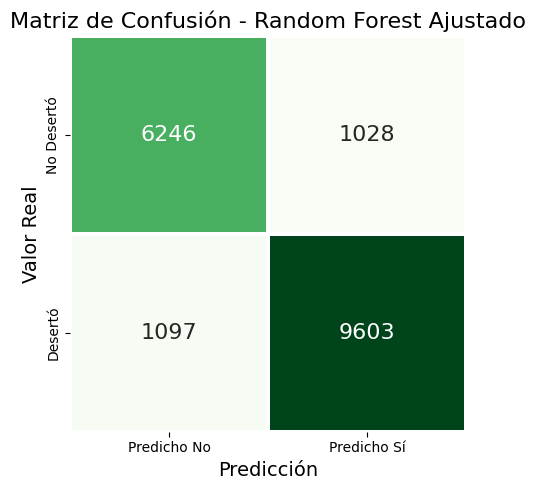

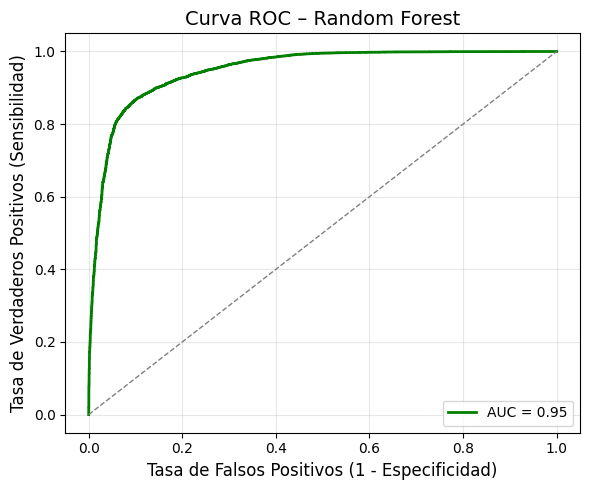

Reporte de Clasificación:

              precision    recall  f1-score   support

  No Desertó     0.8506    0.8587    0.8546      7274
     Desertó     0.9033    0.8975    0.9004     10700

    accuracy                         0.8818     17974
   macro avg     0.8770    0.8781    0.8775     17974
weighted avg     0.8820    0.8818    0.8819     17974


 Métricas en conjunto de prueba (Test):

Accuracy: 0.8792
F1-score: 0.8982
ROC-AUC: 0.9474
Precision: 0.9016
Recall (Sensibilidad): 0.8948
Balanced Accuracy: 0.8756
Specificity: 0.8563


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_19452\2349978379.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_importances.values, y=top_importances.index, palette="Greens_r")


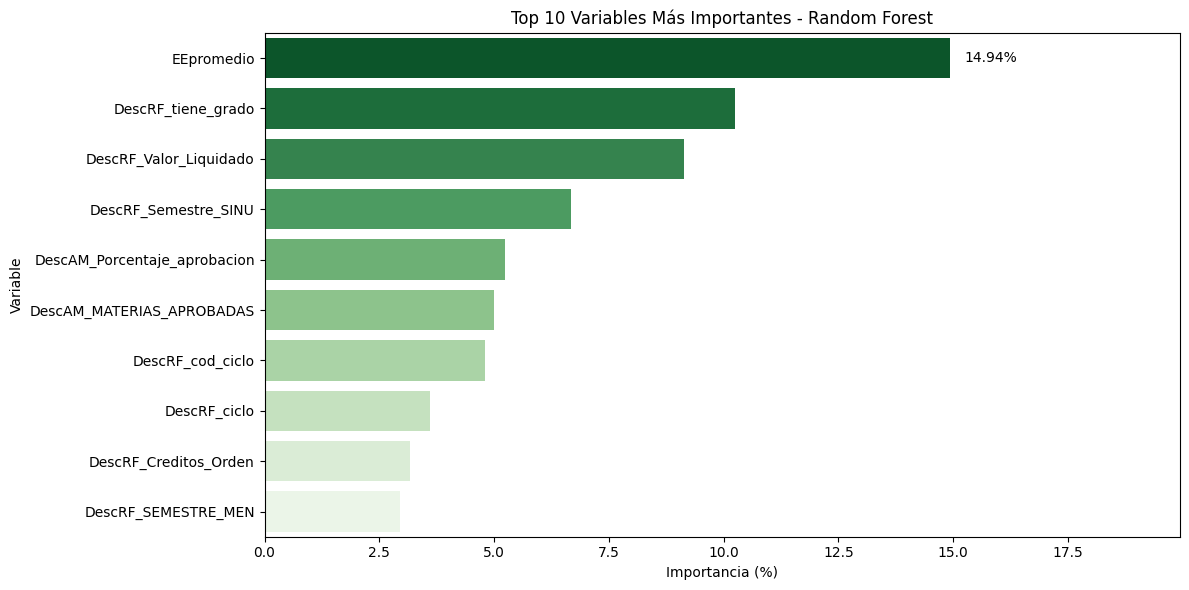

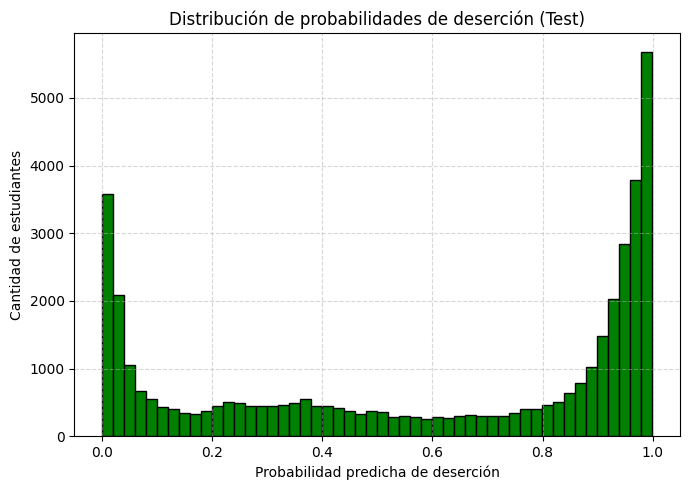

['modelo_rf_tuned.pkl']

In [5]:
# Definir hiperparámetros
param_dist = {
    'n_estimators': [1500], #Cantidad árboles
    'max_depth': [5, 10, 20, None], #Profundida máxima del árbol
    'min_samples_split': [2, 5, 10], # Mínimero muestras para un nodo
    'min_samples_leaf': [1, 2, 4], # Mínimo muestras hoja
    'max_features': ['sqrt', 'log2', None] # Máximo caracteristicas nodo
}

# Modelo base
rf_base = RandomForestClassifier(random_state=42)

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,
    cv=2,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Ajuste de parámetros
random_search.fit(X_train, y_train)
modelo_rf = random_search.best_estimator_

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Predicciones con el modelo ajustado
y_pred = modelo_rf.predict(X_val)
y_proba = modelo_rf.predict_proba(X_val)[:, 1]

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm,
                     index=['No Desertó', 'Desertó'], 
                     columns=['Predicho No', 'Predicho Sí'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens', linewidths=1.5, linecolor='white',
            annot_kws={"size": 16}, cbar=False, square=True)
plt.title('Matriz de Confusión - Random Forest Ajustado', fontsize=16)
plt.ylabel('Valor Real', fontsize=14)
plt.xlabel('Predicción', fontsize=14)
plt.tight_layout()
plt.show()


# Curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
plt.title('Curva ROC – Random Forest', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Métricas
print("Reporte de Clasificación:\n")
print(classification_report(y_val, y_pred, target_names=['No Desertó', 'Desertó'], digits = 4))


# Predicciones y probabilidades sobre el conjunto de prueba
y_pred_test = modelo_rf.predict(X_test)
y_proba_test = modelo_rf.predict_proba(X_test)[:, 1]

# Matriz de confusión para obtener la especificidad
cm_test = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm_test.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Métricas de evaluación en test
print("\n Métricas en conjunto de prueba (Test):\n")
print("Accuracy:", round(accuracy_score(y_test, y_pred_test), 4))
print("F1-score:", round(f1_score(y_test, y_pred_test), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_test), 4))
print("Precision:", round(precision_score(y_test, y_pred_test), 4))
print("Recall (Sensibilidad):", round(recall_score(y_test, y_pred_test), 4))
print("Balanced Accuracy:", round(balanced_accuracy_score(y_test, y_pred_test), 4))
print("Specificity:", round(specificity, 4))


# Importancia de variables
importances = pd.Series(modelo_rf.feature_importances_, index=X.columns)
importances_pct = (importances / importances.sum() * 100).sort_values(ascending=False)

# Mostrar top 10
top_importances = importances_pct.head(10)

plt.figure(figsize=(12, 6))
bars = sns.barplot(x=top_importances.values, y=top_importances.index, palette="Greens_r")

# Agregar etiquetas 
for bar in bars.containers[0]:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}%', va='center', fontsize=10)

plt.title("Top 10 Variables Más Importantes - Random Forest")
plt.xlabel("Importancia (%)")
plt.ylabel("Variable")
plt.xlim(0, top_importances.values.max() + 5)
plt.tight_layout()
plt.show()



# Distribución de probabilidad - TEST
plt.figure(figsize=(7, 5))
plt.hist(y_proba_test, bins=50, color="green", edgecolor="black")
plt.title("Distribución de probabilidades de deserción (Test)")
plt.xlabel("Probabilidad predicha de deserción")
plt.ylabel("Cantidad de estudiantes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Modelo OK
joblib.dump(modelo_rf, 'modelo_rf_tuned.pkl')

### SHAP

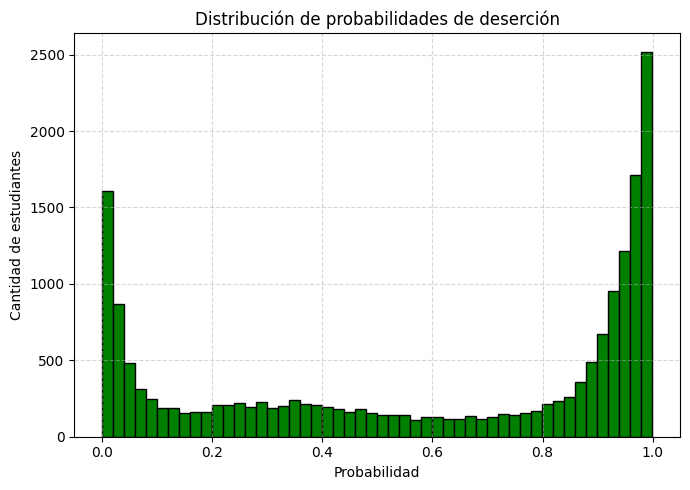

In [6]:
plt.figure(figsize=(7,5))
plt.hist(y_proba, bins=50, color="green", edgecolor="black")
plt.title("Distribución de probabilidades de deserción")
plt.xlabel("Probabilidad")
plt.ylabel("Cantidad de estudiantes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Inicializar SHAP JS
shap.initjs()

# Explicador SHAP para modelo LightGBM
explainer_rf = shap.TreeExplainer(modelo_rf)
shap_values_rf = explainer_rf.shap_values(X_test)

# Convertir a DataFrame
shap_df = pd.DataFrame(shap_values_rf, columns=["SHAP_" + c for c in X.columns])
df_resultado = pd.concat([df_final[["IDescRF_IdentificacionD"]], pd.Series(y_proba, name="ProbabilidadDesercion"), shap_df], axis=1)

# TOP 3 VARIABLES SHAP
def top_3_variables(shap_row, feature_names):
    top_idx = np.argsort(np.abs(shap_row))[-3:][::-1]
    return ", ".join([f"{feature_names[i]} ({shap_row[i]:.2f})" for i in top_idx])

df_resultado["TOP_3_VARIABLES"] = shap_df.apply(lambda row: top_3_variables(row.values, shap_df.columns), axis=1)

# Estudiantes con más riesgo
top_riesgo = df_resultado.sort_values(by="ProbabilidadDesercion", ascending=False).head(5)
print("\n🎯 TOP 5 ESTUDIANTES EN RIESGO")
print(top_riesgo[["DescRF_Identificacion", "ProbabilidadDesercion", "TOP_3_VARIABLES"]])
